# MIE1622 - COMPUTATIONAL FINANCE AND RISK MANAGEMENT 
# ASSIGNMENT 1
# GOKUL RAVI - 1008312309

# Strategies
 For strategies 3 and 4 include mathematical formulation of optimization problem in report and/or in notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex

In [2]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    total_val = cash_init + np.dot(cur_prices,x_init) 
    equal_val = np.ones((20)) * (total_val / 20) # equally allocate money for each asset
    x_optimal = np.floor(equal_val / cur_prices)
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init)) #calculating transaction cost
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
    return x_optimal, cash_optimal

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex() #cplex object creation
    cpx.objective.set_sense(cpx.objective.sense.minimize) #objective set to minimize
    total_val = cash_init + np.dot(cur_prices,x_init) 
    n_stocks = 20
    c = np.zeros((20))
    lb = np.zeros((20)) #lower bound
    ub = np.ones((20)) #upper bound
    
    A = []
    for i in range(n_stocks):
        A.append([[0,1],[1,0]])
    var_names = ['weight_%s'% i for i in range(1,n_stocks+1)] #variable names of weights
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG') #constraint for sum of weights is 1
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n_stocks)),list(2*Q[i,:])] for i in range(n_stocks)] # quadratic part of objective function
    cpx.objective.set_quadratic(qmat) #Objective
    cpx.set_results_stream(None)
    cpx.solve()
    w = np.array(cpx.solution.get_values()) 
    
    money_alloc = w * total_val   #allocation from total value
    x_optimal = np.floor(money_alloc / cur_prices)  #share calculation
    
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex() #cplex object creation
    cpx.objective.set_sense(cpx.objective.sense.minimize) #objective set to minimize
    
    total_val = cash_init + np.dot(cur_prices,x_init) 
    n_stocks = 21 #considering risk-free return as a stock too
    r_riskfree = 0.025
    daily_riskfree = 0.025/252 #on an average 252 trading days
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q1 = np.append(Q1,np.zeros((1,21)),axis=0)
    
    change = np.ones(20) * (mu - daily_riskfree)
    
    A=[]
    for i in range(n_stocks-1):
        A.append([[0,1],[change[i],1.0]])
    A.append([[0,1],[0,-1.0]])
    

    c = [0]*n_stocks
    lb = [0]*n_stocks #lower bound
    ub = [np.inf]*n_stocks #upper bound
    
    var_names = ['sharpe_weight_%s'% i for i in range(1,n_stocks+1)] #variable names of weights
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') #constraint for sum of weights is 1
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    
    qmat = [[list(range(n_stocks)),list(2*Q1[i,:])] for i in range(n_stocks)]  #quadratic part of objective function

    cpx.objective.set_quadratic(qmat)
    cpx.set_results_stream(None)
    cpx.solve()
    
    
    
    result = np.array(cpx.solution.get_values())
    w_maxSharpe = result[0:20]/result[20]

    money_alloc = w_maxSharpe * total_val    #allocation from total value
    x_optimal = np.floor(money_alloc / cur_prices)  #share calculation

    tran_cost = sum(cur_prices * abs(x_optimal-x_init) * 0.005)
    cash_optimal = total_val - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal

# Data loading and Initialization of Portfolios

In [7]:
# Input file
input_file_prices = 'ts2020_2021.csv' # path to ts2020_2021.csv file

# Read data into a dataframe
df = pd.read_csv(input_file_prices)


In [8]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [9]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]


In [10]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']

#N_strat = 3  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe] # uncomment this in your code
#fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance] # comment this in your code


Initial portfolio value = $ 1000012.93



# Running Optimization and printing results

In [11]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices) 
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      if cash[strategy, period-1] < 0:
        portfolio_value = curr_cash + np.dot(cur_prices,curr_positions)
        weight = x[strategy, period-1]/sum(x[strategy, period-1])
        non_cash = weight * abs(cash[strategy, period-1])
        x[strategy, period-1] = x[strategy, period-1] - np.ceil(non_cash/cur_prices)
        tran_cost_1 = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
        cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - tran_cost_1
        
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992758.37, value end = $ 916243.56
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 955991.26, value end = $ 851553.64
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
  Strategy "Equally Weighted Portfolio", v

# Plot Results

## PLOT FOR DAILY VALUE OF PORTFOLIOS

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

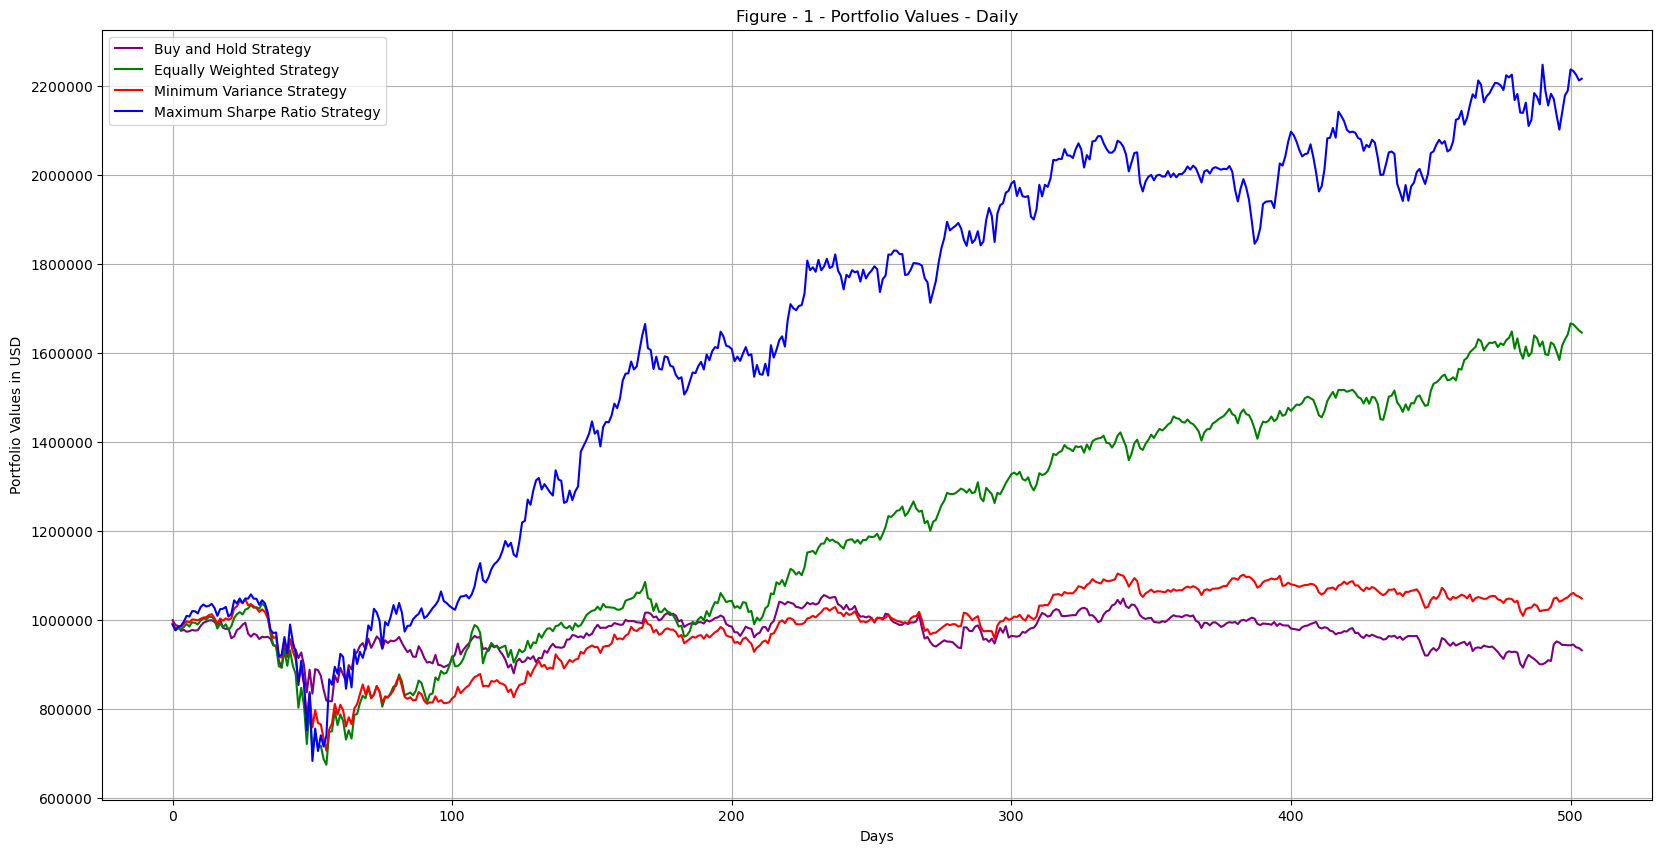

In [13]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold Strategy',color='purple')
plt.plot(portf_value[1],label='Equally Weighted Strategy',color='green')
plt.plot(portf_value[2],label='Minimum Variance Strategy',color='red')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio Strategy',color='blue')
plt.legend()


formatter = ticker.ScalarFormatter(useMathText=True)
plt.gca().yaxis.set_major_formatter(formatter)
formatter.set_scientific(False)


plt.title('Figure - 1 - Portfolio Values - Daily')
plt.xlabel('Days')
plt.ylabel('Portfolio Values in USD')
plt.grid(True)
plt.show()

## DYNAMIC CHANGES PLOT- MINIMUM VARIENCE PORTFOLIO

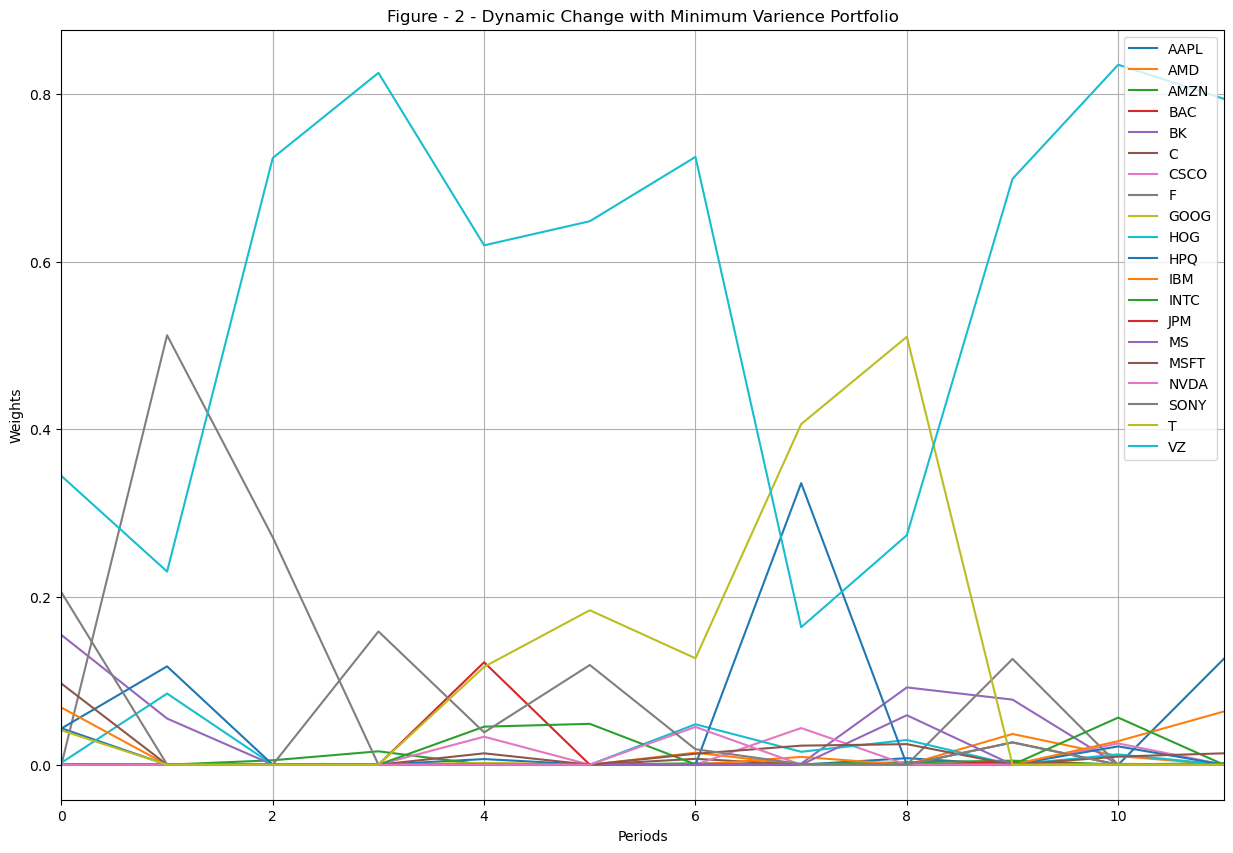

In [14]:
stock_name = df.columns[1:]
w_minVar = []
x[2, period-1], cash[2, period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[2, period - 1] / np.sum(x[2, period - 1])
    w_minVar.append(w_per_period)

# Create DataFrame from the calculated weightings
df_minVar = pd.DataFrame(np.array(w_minVar), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_minVar.columns:
    plt.plot(df_minVar.index, df_minVar[col], label=col)
plt.title('Figure - 2 - Dynamic Change with Minimum Varience Portfolio')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
#plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

In [15]:
df_minVar

,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,HOG,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,0.043515,0.000000,0.000425,0.000000,0.154713,0.000000,0.000000,0.000000,0.000000,0.002339,0.043232,0.068108,0.000000,0.000000,0.000000,0.096740,0.000000,0.205599,0.040964,0.344366
1,0.000000,0.000000,0.000000,0.000000,0.055082,0.000000,0.000000,0.512179,0.000000,0.084873,0.117295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000215,0.000000,0.230355
2,0.000000,0.000000,0.005305,0.000000,0.000000,0.000000,0.000000,0.271173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723522
3,0.000000,0.000000,0.015998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158938,0.000000,0.825064
4,0.006746,0.001728,0.000000,0.122205,0.000000,0.000000,0.033395,0.000000,0.002119,0.000000,0.000000,0.000000,0.045381,0.000000,0.000000,0.013603,0.000167,0.038524,0.116742,0.619390
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048746,0.000000,0.000000,0.000000,0.000000,0.118900,0.184224,0.648131
6,0.000000,0.014346,0.001706,0.000000,0.000000,0.007015,0.000000,0.000000,0.000000,0.048221,0.000000,0.000000,0.000379,0.000000,0.000000,0.013082,0.045061,0.018454,0.126904,0.724831
7,0.000000,0.000000,0.000703,0.000000,0.001282,0.000000,0.043761,0.000000,0.000000,0.015428,0.335815,0.009348,0.000000,0.000000,0.000000,0.022749,0.000000,0.000745,0.406171,0.163999
8,0.007821,0.000000,0.002839,0.000000,0.092190,0.000000,0.000000,0.000000,0.000000,0.029516,0.000000,0.000000,0.000000,0.000000,0.059031,0.024534,0.000000,0.000000,0.510339,0.273730
9,0.000000,0.036671,0.004847,0.002870,0.077615,0.026722,0.000000,0.126148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026467,0.000000,0.698661


## DYNAMIC CHANGES PLOT- MAXIMUM SHARPE RATIO PORTFOLIO

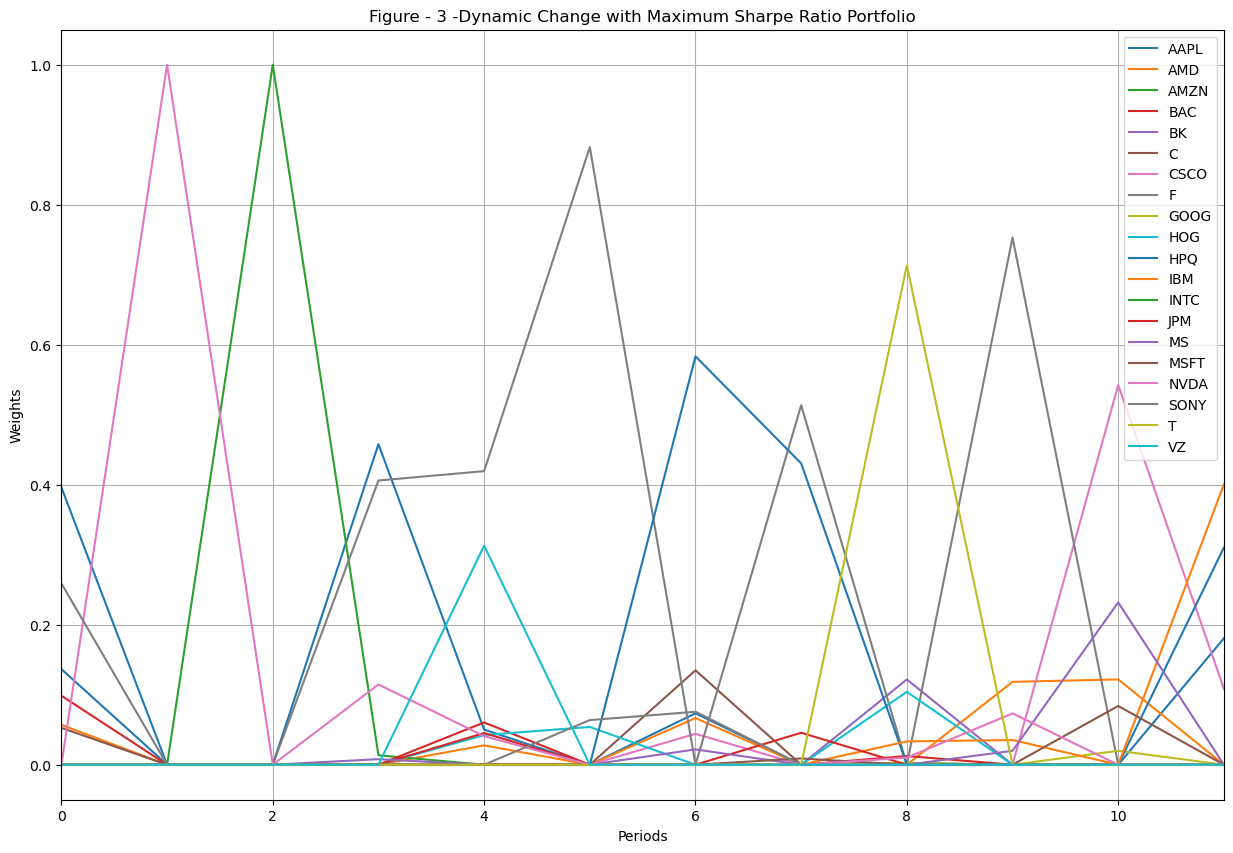

In [16]:
stock_name = df.columns[1:]
w_maxSharpe = []
x[3, period-1], cash[3, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
for period in range(1, N_periods + 1):
    w_per_period = x[3, period - 1] / np.sum(x[3, period - 1])
    w_maxSharpe.append(w_per_period)

# Create DataFrame from the calculated weightings
df_maxSharpe = pd.DataFrame(np.array(w_maxSharpe), columns=stock_name)

# Plotting
plt.figure(figsize=(15, 10))
for col in df_maxSharpe.columns:
    plt.plot(df_maxSharpe.index, df_maxSharpe[col], label=col)
plt.title('Figure - 3 -Dynamic Change with Maximum Sharpe Ratio Portfolio')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.legend(loc='upper right')
#plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xlim(0, 11)  # Set y-axis limits from 0 to 1
plt.grid(True)
plt.show()

In [17]:
df_maxSharpe

,AAPL,AMD,AMZN,BAC,BK,C,CSCO,F,GOOG,HOG,HPQ,IBM,INTC,JPM,MS,MSFT,NVDA,SONY,T,VZ
0,0.136548,0.056992,0.000000,0.098519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.396258,0.000000,0.0,0.000000,0.000000,0.052682,0.000000,0.259000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.457903,0.000000,0.013493,0.000000,0.000000,0.000000,0.000000,0.406014,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.007941,0.000000,0.114649,0.000000,0.000000,0.000000
4,0.050210,0.027667,0.000000,0.060406,0.000000,0.000000,0.000000,0.419415,0.000876,0.042430,0.000000,0.000000,0.0,0.045245,0.000000,0.000000,0.040784,0.000000,0.000000,0.312968
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.882295,0.000000,0.053948,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.063756,0.000000,0.000000
6,0.073439,0.066630,0.000000,0.000000,0.000000,0.134865,0.044152,0.000000,0.000000,0.000000,0.583391,0.000000,0.0,0.000000,0.021841,0.000000,0.000000,0.075682,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.513581,0.001386,0.000000,0.430438,0.000000,0.0,0.045658,0.000000,0.008937,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.002605,0.012450,0.121787,0.000000,0.000000,0.000000,0.002396,0.104102,0.000000,0.033260,0.0,0.000000,0.000000,0.000000,0.010105,0.000000,0.713296,0.000000
9,0.000000,0.118381,0.000000,0.000000,0.000000,0.000000,0.000000,0.753108,0.000000,0.000000,0.000000,0.035317,0.0,0.000000,0.019871,0.000000,0.073324,0.000000,0.000000,0.000000


# VARIATION IN STRATEGY - EQUAL WEIGHT BUY AND HOLD

In [224]:
buy_hold=portf_value[0]
equal_weight=portf_value[1]
minVar=portf_value[2]
maxShar=portf_value[3]

In [225]:
init_prices = data_prices[0,:]
money_alloc = np.ones((20)) * init_value / 20
x_optimal = np.floor(money_alloc / init_prices) # Calculate the shares

In [226]:
def strat_buy_and_hold_equally(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init   
    return x_optimal, cash_optimal

In [227]:
N_strat = 1
fh_array = [strat_buy_and_hold_equally]

In [228]:
# Initial positions in the portfolio changed to Equal Weights as per ou
init_positions = x_optimal

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices) 

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 997980.90, value end = $ 899246.85

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 938232.53, value end = $ 876587.35

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 845360.02, value end = $ 953248.27

Period 4: start date 07/01/2020, end date 08/31/2020
  Strategy "Buy and Hold", value begin = $ 949914.00, value end = $ 1107333.44

Period 5: start date 09/01/2020, end date 10/30/2020
  Strategy "Buy and Hold", value begin = $ 1118785.09, value end = $ 1028924.02

Period 6: start date 11/02/2020, end date 12/31/2020
  Strategy "Buy and Hold", value begin = $ 1036023.49, value end = $ 1209525.72

Period 7: start date 01/04/2021, end date 02/26/2021
  Strategy "Buy and Hold", value begin = $ 1197004.76, value end = $ 1268931.58

Period 8: start date 03/01/2021, end date 04/30/2021
  Strategy "Buy

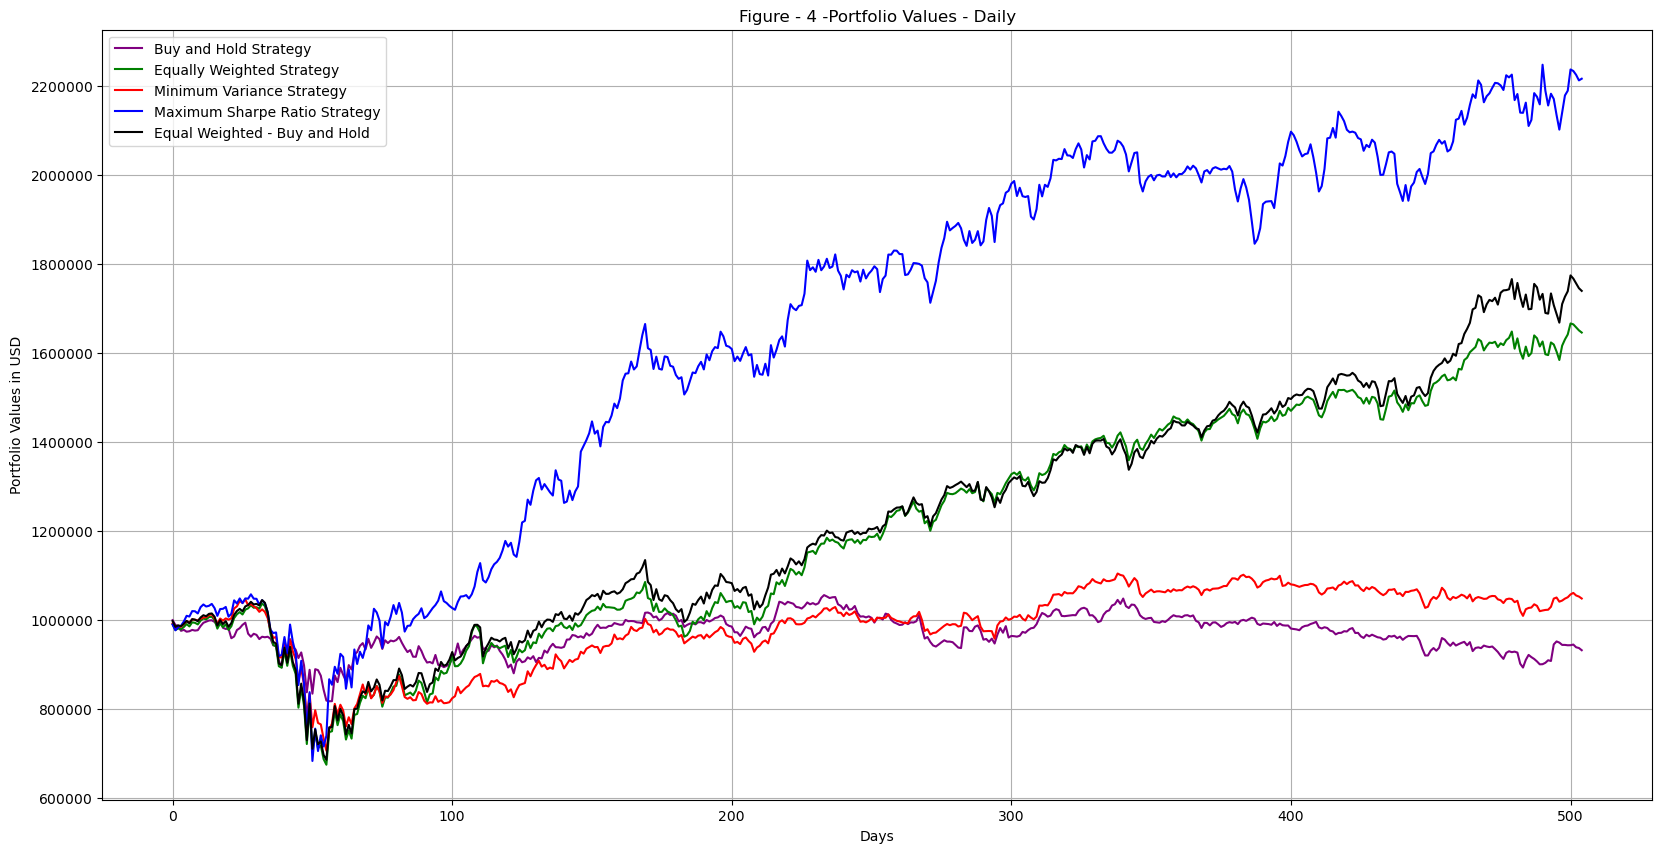

In [229]:
plt.figure(figsize=(20,10))
plt.plot(buy_hold,label='Buy and Hold Strategy',color='purple')
plt.plot(equal_weight,label='Equally Weighted Strategy',color='green')
plt.plot(minVar,label='Minimum Variance Strategy',color='red')
plt.plot(maxShar,label='Maximum Sharpe Ratio Strategy',color='blue')
plt.plot(portf_value[0],label='Equal Weighted - Buy and Hold',color='black')
plt.legend()


formatter = ticker.ScalarFormatter(useMathText=True)
plt.gca().yaxis.set_major_formatter(formatter)
formatter.set_scientific(False)


plt.title('Figure - 4 -Portfolio Values - Daily')
plt.xlabel('Days')
plt.ylabel('Portfolio Values in USD')
plt.grid(True)
plt.show()